In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


Image shape: (659, 1277, 3)
BGR2RGB


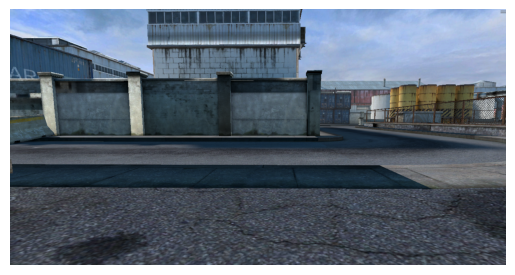

In [11]:
image = cv2.imread('test_fp.png')

# Check the dimensions of the image array
print("Image shape:", image.shape)

# If the image is in BGR format (common in OpenCV), convert it to RGB for display
if len(image.shape) == 3 and image.shape[2] == 3:
    print('BGR2RGB')
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()
elif len(image.shape) == 3 and image.shape[2] == 4:
    print('BGRA2RGBA')
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()
    
image = image_rgb

In [7]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry,SamPredictor

sam_checkpoint = "./models/sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)


In [8]:
predictor.set_image(image)

方法一：使用单个提示点进行目标分割

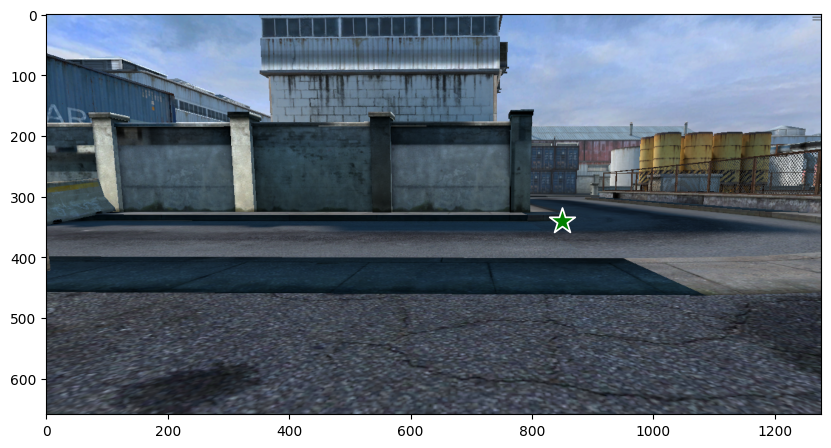

In [22]:
# 单点 prompt  输入格式为(x, y)和并表示出点所带有的标签1(前景点)或0(背景点)。
input_point = np.array([[850, 340]])  # 标记点
input_label = np.array([1])  # 点所对应的标签

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()


In [24]:
#用 SamPredictor.predict进行分割，模型会返回这些分割目标对应的置信度
masks, scores, logits = predictor.predict(
	    point_coords=input_point,
	    point_labels=input_label,
	    multimask_output=True,
	)
		


(3, 659, 1277)


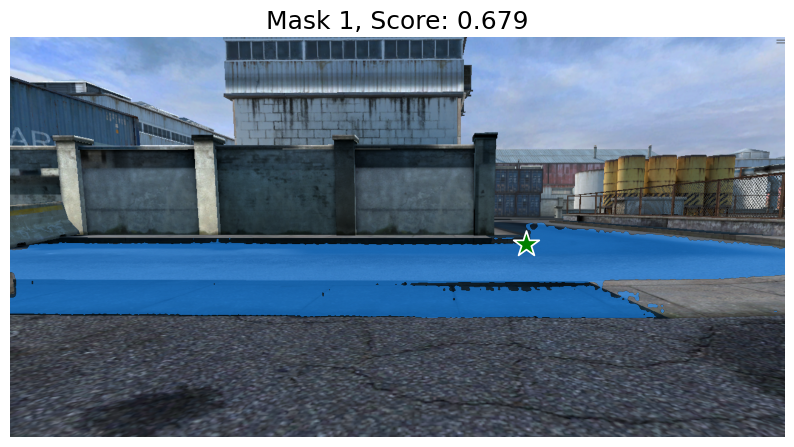

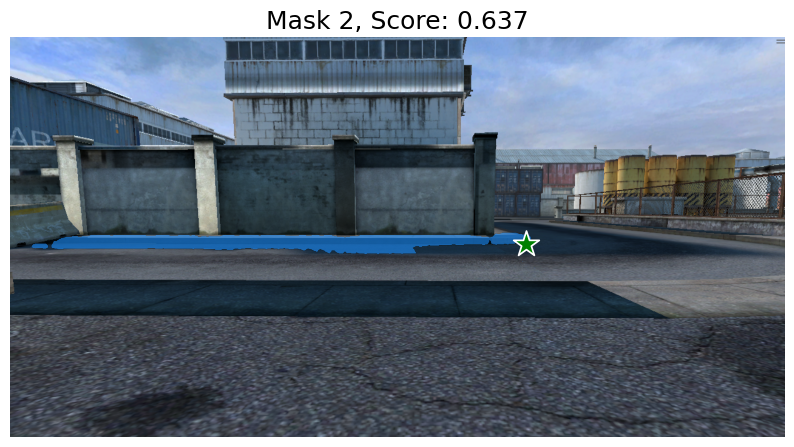

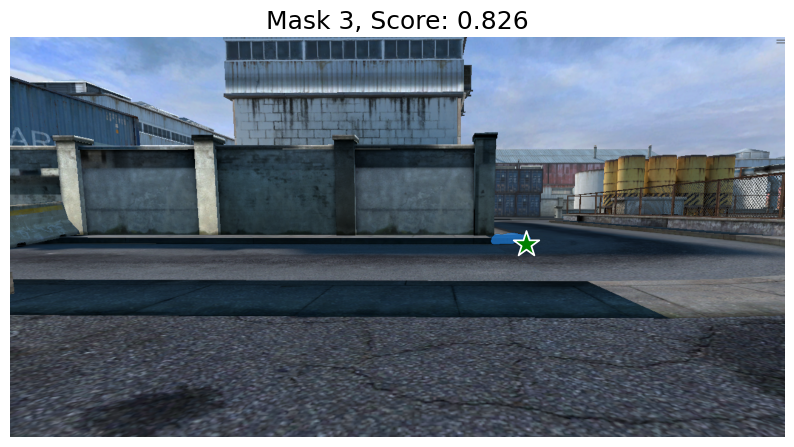

In [25]:
print(masks.shape)  # (number_of_masks) x H x W
		
# 三个置信度不同的图
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()


3.5.2 方法二：使用多个提示点进行目标分割
单个提示点通常会存在歧义的影响，因为可能多个目标均包含该点。为了得到我们想要的单个目标，我们可以在目标上进行多个点的提示，以获取该目标的分割结果。如果我们想要剔除，可以使用背景点（label=0），将其他部分剔除掉。

多点prompt


(1, 659, 1277)


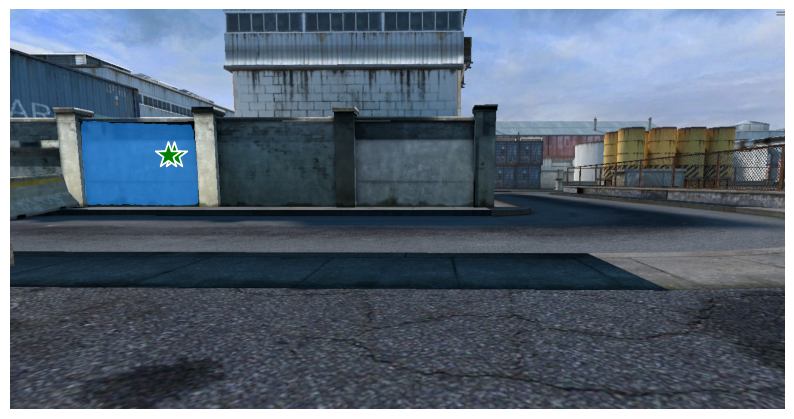

In [26]:
input_point = np.array([[270, 240], [260, 240]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

print(masks.shape)

plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()


方法三：用方框指定一个目标进行分割
SAM模型可以用一个方框作为输入，格式为[x1,y1,x2,y2]。来进行单个目标的分割，如下面所示，通过方框对车的轮子进行分割。

In [27]:
# 方框prompt SAM模型可以用一个方框作为输入，格式为[x1,y1,x2,y2],左上，右下。来进行单个目标的分割
			
def box_prompt():
    input_box = np.array([200, 200, 370, 290])

    masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=False,
    )

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_mask(masks[0], plt.gca())
    show_box(input_box, plt.gca())
    plt.axis('off')
    plt.show()


方法四： 将点与方框结合，进行目标分割
通过方框和点配合使用，更加准确。

In [ ]:
 #将点与方框结合，进行目标分割
def box_point_prompt():
    input_box = np.array([200, 200, 370, 290])
    input_point = np.array([[270, 240]])
    input_label = np.array([1])

    masks, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        box=input_box,
        multimask_output=False,
    )

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_mask(masks[0], plt.gca())
    show_box(input_box, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.axis('off')
    plt.show()


方法五：多个方框同时输入，进行多目标分割
通过同时输入多个方框，可用于分割不同方框中的目标。

多个方框同时输入，进行多目标分割

In [ ]:
def multi_box_prompt():
    input_boxes = torch.tensor([
        [200, 200, 350, 290],
        [220, 300, 290, 340],

    ], device=predictor.device)

    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
    masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )
    print(masks.shape)  # x H x W

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for mask in masks:
        show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
    for box in input_boxes:
        show_box(box.cpu().numpy(), plt.gca())
    plt.axis('off')
    plt.show()


: 